In [2]:
import os
import sys
import torch
from torch import Tensor
import torch.testing as torch_testing
import torch.nn as nn
import numpy as np
import numpy.testing as npt
from functools import reduce
import matplotlib.pyplot as plt
import os
import pickle
import cv2
from dataclasses import dataclass

Let's start by implementing the softmax function. This function takes as input an array of *N* arbitrary numbers and normalizes the array such that the output is a probability distribution.


\begin{equation}
softmax(x)_i = \frac{e^{x_i}}{\sum_{j = 0}^{j = N} e^{x_j}}
\end{equation}

In the file *activations.py* write the implementation of the softmax function.

**Short discussion about softmax numerical stability.** You can also check this [post](https://ogunlao.github.io/2020/04/26/you_dont_really_know_softmax.html).

This code is found in _activations.py_ .

In [3]:
def softmax_without_temperature(input_array):
    return np.exp(input_array)/np.sum(np.exp(input_array))

def softmax_with_temperature(input_array, temperature):
    return np.exp(input_array/temperature)/np.sum(np.exp(input_array/temperature))

input_array = np.array([np.log(1), np.log(2), np.log(3), np.log(4)])
result_without_temperature = softmax_without_temperature(input_array)
result_with_temperature = softmax_with_temperature(input_array, 1)

# My validation of both softmax
npt.assert_almost_equal([0.1, 0.2, 0.3, 0.4], result_without_temperature)
npt.assert_almost_equal([0.1, 0.2, 0.3, 0.4], result_with_temperature)

In [4]:
# Validation of softmax without temperature
arr = np.asarray([2, 4, 10, 100, 2.0])
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax_without_temperature(arr)))
arr = np.asarray([0.0, 0, 0, 1, 0])
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax_without_temperature(arr)))
arr = np.asarray([-750.0, 23, 9, 10, 230])
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax_without_temperature(arr)))
arr = np.ones((4, ))
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax_without_temperature(arr)))
arr = np.zeros((4, ))
# Validation of softmax with temperature
arr = np.asarray([2, 4, 10, 100, 2.0])
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax_with_temperature(arr, 1)))
arr = np.asarray([0.0, 0, 0, 1, 0])
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax_with_temperature(arr, 1)))
arr = np.asarray([-750.0, 23, 9, 10, 230])
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax_with_temperature(arr, 1)))
arr = np.ones((4, ))
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax_with_temperature(arr, 1)))
arr = np.zeros((4, ))

*Softmax temperature* is a concept that we'll be using later in this course.
The *softmax temperature* is a hyper-parameter (positive number) which scales the input of the softmax function to modify the output probabilities.
\begin{equation}
s(x, T)_i = \frac{e^{x_i/T}}{\sum_{j = 0}^{j = N} e^{x_j/T}}
\end{equation}

Now modify your implementation of the softmax function such that it also takes as input the softmax temperature (a positive floating point number). If this parameter is not specified, it should default to 1.

Now let's visualise what is the effect of the softmax temperature.
Given the input vector *x = [100, 2, -150, 75, 99, 3]* , plot the original vector and the softmax with temperatures $ T \in \{0.25, 0.75, 1, 1.5, 2, 5, 10, 20, 30\} $.

You can use a bar plot for this. The title for each plot should be the value of the softmax temperature. Also, make sure that for all the plots the range of the *y* axis is set to (0, 1).

This code is found in _activations.py_ .

<Figure size 1440x720 with 0 Axes>

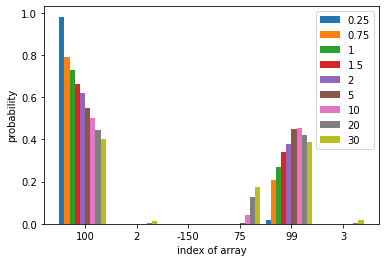

In [5]:
initial_vector = np.array([100, 2, -150, 75, 99, 3])
temperatures = [0.25, 0.75, 1, 1.5, 2, 5, 10, 20, 30]
indices_in_initial_vector = np.arange(len(initial_vector))
figure_width = 20
figure_height = 10
plt.figure(figsize=(figure_width, figure_height))
bar_width = 0.1
fig, ax = plt.subplots()

for index, temperature in enumerate(temperatures):
    ax.bar(indices_in_initial_vector+index*bar_width, softmax_with_temperature(initial_vector, temperature), bar_width, label=str(temperature))
    npt.assert_almost_equal(np.sum(softmax_with_temperature(initial_vector, temperature)), 1.0)

ax.set_xticks(indices_in_initial_vector + bar_width*len(temperatures) / 2)
ax.set_xticklabels(initial_vector)
plt.xlabel('index of array')
plt.ylabel('probability')
plt.legend()

1. What happens when we use a large number for the softmax temperature?

Answear: The probability distribution becomes more uniform.

2. What happens when we use a small number (i.e. less than 1) for the softmax temperature?

Answear: The probability distribution becomes less uniform.

3. In the context of image classification, the predicted class is determined by taking the *argmax* of the softmax function. Does the softmax temperature change in any way this prediction?

Answear: Nope, based on the last example

In the script *cifar10.py* you will complete the function ``load_cifar10``, which load the data from the archive you just downloaded.

The images of this dataset are are stored in a numpy array, one image per row, in the following order:

"_The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image._"

Your task here is just to manipulate this array, such that each image has the shape (32, 32, 3) and uses RGB ordering.

In [6]:
labels = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
number_of_classes = len(labels)

In [7]:
def load_file(file_path: str) -> (np.ndarray, np.ndarray):
    """"
    Load a single batch file.
    This function only reshape the image from 1000 rows of 32(rows)*32(columns)*3(channels) to 1000 rows to a rgb format.
    Basically each line should contain at the end 32 rows * 32 columns * 3 channels = 3072 values.
    Initial shape: (10000, 3072)
    Final shape: (10000, 32, 32, 3)
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
        all_images = data['data']
        number_of_images = all_images.shape[0]
        y = data['labels']
        reshaped_and_transpose_images = all_images.reshape(number_of_images, 3, 32, 32).transpose(0, 2, 3, 1)
        return reshaped_and_transpose_images, np.asanyarray(y)
reshaped_images, _ = load_file("batches/data_batch_1")

In [8]:
def load_directory(directory_path: str) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Load multiple batch files.
    Train data start with: data_batch_[...].
    Test data file is test_batch.
    """
    #Train data
    train_batches = [os.path.join(directory_path, 'data_batch_{}'.format(i)) for i in range(1, 6)]
    all_images_directory = []
    all_labels_directory = []
    for batch in train_batches:
        all_images_file, all_labels_file = load_file(batch)
        all_images_directory.extend(all_images_file)
        all_labels_directory.extend(all_labels_file)
    all_images_directory = np.asarray(all_images_directory)
    all_labels_directory = np.asarray(all_labels_directory)
    # Test data
    test_batches = os.path.join(directory_path, 'test_batch')
    test_images, test_labels = load_file(test_batches)
    assert(all_images_directory.shape[0] == 50000)
    assert(all_images_directory[0].shape == (32, 32, 3))
    assert(all_images_directory.shape[0] == all_labels_directory.shape[0])
    assert (test_images.shape[0] == 10000)
    assert (test_images[0].shape == (32, 32, 3))
    assert (test_images.shape[0] == test_labels.shape[0])

    return all_images_directory, all_labels_directory, test_images, test_labels

def load_directory_and_apply_tricks(directory_path: str) -> (Tensor, Tensor, Tensor, Tensor):
    X_train, Y_train, X_test, Y_test = load_directory("batches")
    
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    n_values = np.max(Y_train) + 1
    Y_train = np.eye(n_values)[Y_train]
    
    X_test = X_test.reshape(X_test.shape[0], -1)
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    n_values = np.max(Y_test) + 1
    Y_test = np.eye(n_values)[Y_test]
    
    return torch.from_numpy(X_train), torch.from_numpy(Y_train), torch.from_numpy(X_test), torch.from_numpy(Y_test)
X_train, Y_train, X_test, Y_test = load_directory_and_apply_tricks("batches")

Now let's visualize some of the images from the CIFAR-10 dataset.

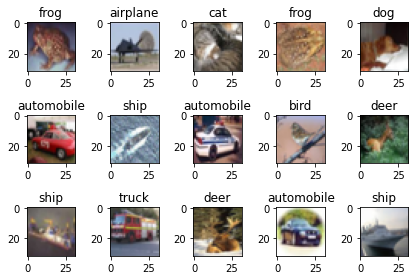

In [9]:
X_train, Y_train, X_test, Y_test = load_directory("batches")
number_of_images = 15
number_of_displayed_rows = 3
number_of_displayed_collumns = number_of_images // number_of_displayed_rows
random_image_indexes = np.random.choice(len(X_test), number_of_images)
chosed_images, chosed_labels = X_test[random_image_indexes], Y_test[random_image_indexes]
for image_index, (test_image, test_label) in enumerate(zip(chosed_images, chosed_labels)):
    plt.subplot(number_of_displayed_rows, number_of_displayed_collumns, image_index + 1)
    plt.imshow(test_image)
    plt.title(labels[test_label])
    plt.tight_layout()
plt.show()

Linear classification -> Liniar function is used to map from input data to output data using the formula:


\begin{equation}
f(X_i) = X_i \cdot W + b
\end{equation}

W -> the weights.

b -> the bias.

We need a loss function to know if we are close to the answer or not. We will use this loss function to better train the model.

We can get rid of the bias by extending the input metric by one and the weight metric with the byas.

X from [1, 2, 3] -> [1, 2, 3, 1]

W= 
[
[1, 2]
[3, 4]
]
& B= [5, 6]
=>
W =
[
[1, 2]
[3, 4]
[5, 6]
]

NEW FORMULA:

\begin{equation}
f(X_i) = X_i \cdot W
\end{equation}

<!-- ```
X = np.hstack([X, np.ones((X.shape[0], 1))])
``` -->


## Implementation

[Pytorch](https://pytorch.org/) -> machine learning framework

[Tensors](https://pytorch.org/docs/stable/tensors.html) -> main data abstraction from pytorch

`Tensor` components:
- Data: usefull data
- Metadata: dtype, device that the tensors lives on

We can transorm a `numpy` array into/from a tensor: _from_numpy()_, _numpy()_

_item()_ -> to a scalar python value

`_autograd_`
- automatic differentiation of arbitrary scalar valued functions
- set `_requires_grad_` to true
- We need differential equation, so we can find a maximum point of the main function we need to optimize.

`Softmax classification`
| Method | Description |
| ----------- | ----------- |
| initialize() | Randomly initialize the weights |
| fit(X_train, y_train, **kwargs) | This will be used for training. |
|  predict(X) | Return the predicted class |
|  predict_proba(X) | Return the classifier predictions |
|  save(path) | Will save the weights to a file |
|  load(load) | Load the weigths from a file |
|  __init__ | Take the size of input image and number of output classes |

fill in the `_initialize()_` method. You figure out the shape of the weight matrix based on the input shape and the number of classes. Initialize the weight matrix with small random variables.

In [170]:
@dataclass
class Parameters():
    weight: Tensor
    number_of_classes: int
    input_shape: np.shape
    loss_evolution: list
    accuracy_evolution: list

X_train, Y_train, X_test, Y_test = load_directory_and_apply_tricks("batches")

test_input_shape = X_train[0].shape
test_number_of_classes = Y_train.shape[1]




In [123]:
def initialize(number_of_classes: int, input_shape):
    weight = torch.randn(input_shape[0], number_of_classes, dtype=float) * 0.001
    weight.requires_grad_(True)
    return Parameters(weight, number_of_classes, input_shape, [], [])

parameters = initialize(number_of_classes, test_input_shape)

npt.assert_equal((test_input_shape[0], test_number_of_classes), parameters.weight.shape)
npt.assert_equal(test_number_of_classes, parameters.number_of_classes)
npt.assert_equal(test_input_shape, parameters.input_shape)
npt.assert_equal(True, parameters.weight.requires_grad)
npt.assert_equal([], parameters.loss_evolution)

fill in the `_save_` and `_load_` functions. In these functions you should just dump and restore, respectively, the weight matrix to/from the specified file.

In [12]:
def save(parameters: Parameters, file_path: str):
    torch.save(parameters, file_path)
    return file_path
def load(file_path: str) -> Parameters:
    return torch.load(file_path)

parameters = initialize(test_number_of_classes, test_input_shape)
save(parameters, "parameters.torch")
parameters_loaded = load("parameters.torch")

npt.assert_equal(parameters.weight.shape, parameters_loaded.weight.shape)
npt.assert_equal(parameters.number_of_classes, parameters_loaded.number_of_classes)
npt.assert_equal(parameters.input_shape, parameters_loaded.input_shape)

`_predict_` - this will just return the predicted class label. So you just need to compute the dot product and take the argmax of the result.

In [13]:
def predict(parameters: Parameters, input: Tensor, dim=0) -> Tensor:
    result = input @ parameters.weight
    return torch.argmax(result, dim=dim)

parameters = initialize(test_number_of_classes, test_input_shape)
for _ in range(1000):
    Y_pred = predict(parameters, X_train[0])
    npt.assert_equal(True, (Y_pred < test_number_of_classes).item())
    
    Y_pred = predict(parameters, X_train[0:3], dim=1)
    npt.assert_equal(True, (torch.max(Y_pred) < test_number_of_classes).item())

`predict_proba` - this will return the class probabilities. So after computing the dot product, you also need to apply the softmax function on the result to normalize it to a probability distribution.

In [14]:
def predict_proba(parameters: Parameters, input: Tensor, dim=0) -> Tensor:
    result = input @ parameters.weight
    return torch.nn.functional.softmax(result, dim=dim)

parameters = initialize(test_number_of_classes, test_input_shape)
for _ in range(1000):
    predicted_proba = predict_proba(parameters, X_train[0])
    npt.assert_almost_equal(1.0, np.sum(predicted_proba.detach().numpy()), decimal=5)

    predicted_proba = predict_proba(parameters, X_train[0:3], dim=1)
    npt.assert_almost_equal(1.0, torch.sum(predicted_proba, dim=1).detach().numpy(), decimal=5)

Example of prediction using the model:

In [15]:
parameters = initialize(test_number_of_classes, test_input_shape)

print('Predicted class ', labels[predict(parameters, X_test[0])], predict(parameters, X_test[0]))
print('Probas: ', predict_proba(parameters, X_test[0]).detach().numpy())
print('[MULTI] Predicted class ', labels[predict(parameters, X_test[0:3], dim=1)], predict(parameters, X_test[0:3], dim=1))
print('[MULTI] Probas: ', predict_proba(parameters, X_test[0:3], dim=1).detach().numpy())

Predicted class  automobile tensor(1)
Probas:  [1.53123299e-05 9.72897475e-01 2.13542065e-04 1.69116980e-03
 5.03865130e-09 1.88539401e-02 9.13714112e-07 1.29022189e-06
 6.20737515e-03 1.18976567e-04]
[MULTI] Predicted class  ['automobile' 'cat' 'automobile'] tensor([1, 3, 1])
[MULTI] Probas:  [[1.53123299e-05 9.72897475e-01 2.13542065e-04 1.69116980e-03
  5.03865130e-09 1.88539401e-02 9.13714112e-07 1.29022189e-06
  6.20737515e-03 1.18976567e-04]
 [4.99247224e-03 2.54397995e-01 4.32875975e-06 7.18727420e-01
  6.63432886e-14 9.60413291e-06 1.65296955e-09 4.58150476e-06
  2.18465029e-02 1.70939941e-05]
 [4.15286969e-07 9.99896219e-01 3.14375572e-07 4.70686424e-05
  1.48691792e-14 4.79385757e-07 3.41897407e-11 4.05867985e-09
  4.82698911e-05 7.22902962e-06]]


`Training` - the _fit_ method

Usefull for making accurate predictions.

Pytorch provides a powerful feature, _autograd_: it allows for the rapid and easy computation of multiple partial derivatives (also referred to as gradients) over a complex computation. This operation is central to backpropagation-based neural network learning.

You can follow [this](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html) post for more details about how autograd works.
We'll cover autograd in more detail in the next labs.

For now, we'll be using it to make your life easier when implementing gradient descent to train the softmax classifier. In gradient descent, the idea is to take repeated steps in the opposite direction of the gradient of the loss function at the current point. The backpropagation algorithm works by computing the gradient of the loss function with respect to each weight by the chain rule, computing the gradient one layer at a time, and iterating backward from the last layer to avoid redundant calculations of intermediate terms in the chain rule.

To signal autograd that it should collect the gradients of a tensor, you need to pass the parameter _requires_grad=True_ when creating it or call the method _requires_grad_()_ on a tensor.

To __start the backpropagation__ with autograd, you just need to call the _backward()_ function on the loss tensor (a scalar).  
Autograd calculates and stores the gradients for each model parameter in the tensors' _grad_ field.

Let's see how a custom training loop looks in pytorch:

```python
lr = 0.05  # learning rate: what is the size of the step that we will take in the opposite direction of the gradient
epochs = 32  # how many epochs (passes through the traing data) we'll peform
bs = 32 # batch size:  we'll update the parameters after seeing several examples (a batch of data)

for epoch in range(epochs):    
    for ii in range((X_train.shape[0] - 1) // bs + 1):  # in batches of size bs
        start_idx = ii * bs  # we are ii batches in, each of size bs
        end_idx = start_idx + bs  # get bs examples

        # get the training training examples xb, and their coresponding annotations
        xb = X_train[start_idx:end_idx]
        yb = y_train[start_idx:end_idx]

        # apply the model on the training examples
        pred = predict_proba(xb)

        # compute the loss function
        loss = cross_entropy_loss(pred, yb)

        # start backpropagation: calculate the gradients with a backwards pass
        loss.backward()

        # update the parameters
        with torch.no_grad():  # we don't want to track gradients
            # take a step in the negative direction of the gradient, the learning rate defines the step size
            weights -= weights.grad * lr

            # ATTENTION: you need to explictly set the gradients to 0 (let pytorch know that you are done with them).
            weights.grad.zero_()
            
``




Loss function definition (`cross_entropy`):
\begin{equation}
L_i = - \sum_{i=1}^{C} log(\hat{y\_pred}_i)\cdot y_i.
\end{equation}

$\hat{y\_pred}_i$ is always a value in the interval [0, 1]

close to 0 => loss is very high (infinite)
close to 1 => loss is very low (0)

In [16]:
def cross_entropy_loss(Y_pred: Tensor, Y: Tensor, dim=0) -> Tensor:
    return -torch.sum(Y * torch.log(Y_pred), dim=dim)

pytorch_loss = torch.nn.CrossEntropyLoss()
parameters = initialize(test_number_of_classes, test_input_shape)
predicted_output = predict_proba(parameters, X_train[0])

my_loss = cross_entropy_loss(predicted_output, Y_train[0]).detach().numpy()
pytorch_loss = cross_entropy_loss(predicted_output, Y_train[0]).detach().numpy()
my_multiple_loss = cross_entropy_loss(predicted_output, Y_train[0:3], dim=1).detach().numpy()
pytorch_multiple_loss = cross_entropy_loss(predicted_output, Y_train[0:3], dim=1).detach().numpy()

print(f"My loss:\n{my_loss}\n")
print(f"Pytorch loss:\n{pytorch_loss}\n")
print(f"My multiple loss:\n{my_multiple_loss}\n")
print(f"Pytorch multiple loss:\n{pytorch_multiple_loss}\n")
npt.assert_equal(my_loss, pytorch_loss)
npt.assert_equal(my_multiple_loss, pytorch_multiple_loss)

My loss:
12.503744579535192

Pytorch loss:
12.503744579535192

My multiple loss:
[1.25037446e+01 1.96036113e-03 1.96036113e-03]

Pytorch multiple loss:
[1.25037446e+01 1.96036113e-03 1.96036113e-03]



In the function `log_softmax` implement the following:
\begin{equation}
log\_softmax(x_i) =  log(\frac{e^{x_i}}{\sum_{j}e^{x_j}}) = x_i - log(\sum_j e^x_j)
\end{equation}

In [17]:
def log_softmax(input: Tensor) -> Tensor:
    return input - torch.log(torch.sum(torch.exp(input)))

pytorch_log_softmax = nn.LogSoftmax(dim=0)

my_log_softmax = log_softmax(X_train[0]).numpy()
pytorch_log_softmax = pytorch_log_softmax(X_train[0]).numpy()
# my_multiple_log_softmax = log_softmax(X_train[0:3], dim=1).numpy()
# pytorch_multiple_log_softmax = pytorch_log_softmax(X_train[0:3]).numpy()

print(f"My log softmax:\n{my_log_softmax}\n")
print(f"Pytorch log softmax:\n{pytorch_log_softmax}\n")
# print(f"My multiple log softmax:\n{my_multiple_log_softmax}\n")
# print(f"Pytorch multiple log softmax:\n{pytorch_multiple_log_softmax}\n")
npt.assert_almost_equal(my_log_softmax, pytorch_log_softmax)
# npt.assert_almost_equal(my_multiple_log_softmax, pytorch_multiple_log_softmax)

My log softmax:
[-196.8113879 -193.8113879 -192.8113879 ... -163.8113879 -183.8113879
 -254.8113879]

Pytorch log softmax:
[-196.8113879 -193.8113879 -192.8113879 ... -163.8113879 -183.8113879
 -254.8113879]



Then, in the ``fit`` method:
\begin{equation}
y\_pred_i = f(x_i)
\end{equation}

\begin{equation}
\hat{y\_pred_i} =  log\_softmax(y\_pred_i)
\end{equation},

and take the cross entropy loss between $\hat{y\_pred_i}$ and $y_i$ to compute the data loss.

For this we need two steps:
1. we need to define a loss function that quantifies our
how well is the classifier doing on the training data. The loss function that we will use is the **cross entropy loss**.
Remember from the lecture that, in order to avoid overfitting, a regularization term is added to the loss function.
You will implement the $L_2$ regularization, in which you also add the  sum of squares of all of the feature weights to the loss.


2. we need an algorithm to efficiently find the
parameters that minimize the loss function.

In [153]:
X_train, Y_train, X_test, Y_test = load_directory_and_apply_tricks("batches")

In [155]:
def compute_accuracy(parameters: Parameters, input: Tensor, reverted_Y: Tensor) -> float:
    with torch.no_grad():
        computed_Y = predict(parameters, input, dim=1)
    return torch.mean((reverted_Y == computed_Y).float())

In [166]:
def fit(parameters: Parameters, train_data: torch.Tensor, train_result: torch.Tensor, **kwargs) -> Parameters:
    learning_rate = kwargs.get("learning_rate", 1e-7)
    epochs = kwargs.get("epochs", 10)
    batch_size = kwargs.get("batch_size", 100)
    regularization_strength = kwargs.get("regularization_strength", 1e3)
    number_of_iteration_to_map_all_images = train_data.shape[0] // batch_size
    
    # Handle the update of weights
    optimizer = torch.optim.SGD([parameters.weight], lr=learning_rate, weight_decay=regularization_strength)
    
    for _ in range(epochs):
        sum_loss = 0
        for current_image_index in range(number_of_iteration_to_map_all_images):
            from_image = current_image_index * batch_size
            to_image = from_image + batch_size
            
            current_image_data = train_data[from_image:to_image]
            current_image_result = train_result[from_image:to_image]

            predicted = predict_proba(parameters, current_image_data, dim=1)
            loss = cross_entropy_loss(predicted, current_image_result, dim=1)
            
            optimizer.zero_grad()
            loss.mean(dim=0).backward()
            optimizer.step()
            sum_loss += loss.mean().item()
        parameters.loss_evolution.append(sum_loss)

parameters = initialize(Y_train.shape[1], X_train[0].shape)
fit(parameters, X_train, Y_train)
save(parameters, "model_trained.torch")

'model_trained.torch'

Train accuracy: 0.3214600086212158
Loss evolution: [1720.9150879272256, 1382.5155686672988, 1259.042463063157, 1181.4410562445655, 1126.1137341663632, 1084.0928253289585, 1050.9626636836392, 1024.2031047622909, 1002.2249604281643, 983.9530968405023]
Reverted y shape: (50000,)


Text(0, 0.5, 'Loss')

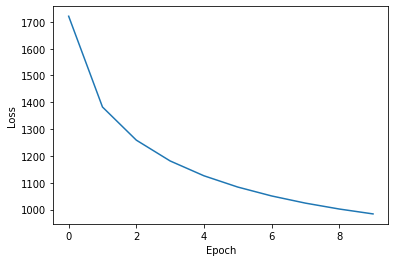

In [169]:
parameters = load("model_trained.torch")
reverted_Y = np.argmax(Y_train, axis=1)

train_acc = compute_accuracy(parameters, X_train, reverted_Y)
print(f"Train accuracy: {train_acc}")
print(f"Loss evolution: {parameters.loss_evolution}")
print(f"Reverted y shape: {reverted_Y.numpy().shape}")
plt.plot(parameters.loss_evolution)
plt.xlabel('Epoch')
plt.ylabel('Loss')